# Helical actuator
- Code for 3D large deformation electro-elasticity with u-p formulation

- Electro-elastic actuation of a helical actuator

### Units
- Length: mm
- Mass: kg  
- Time:  s
- Charge: nC
- Force: mN
- Stress: kPa 
- Electric potential: kV

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [25]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, acos, ge, le, outer)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [26]:
# Read in the 3D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/helix.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 2D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_helix.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell index numbers**

In [27]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indice

[542]


In [28]:
# # Identify the planar boundaries of the  box mesh
# #
# def xBot(x):
#     return np.isclose(x[0], 0)
# def xTop(x):
#     return np.isclose(x[0], length)
# def yBot(x):
#     return np.isclose(x[1], 0)
# def yTop(x):
#     return np.isclose(x[1], length)
# def zBot(x):
#     return np.isclose(x[2], 0)
# def zTop(x):
#     return np.isclose(x[2], length)
    
# # Mark the sub-domains
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# # build collections of facets on each subdomain and mark them appropriately.
# facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
# fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
# for (marker, locator) in boundaries:
#     facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
#                                                          # given subdomain ("locator")
#     facet_indices.append(facets)                         # add these facets to the collection.
#     facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# # Format the facet indices and markers as required for use in dolfinx.
# facet_indices = np.hstack(facet_indices).astype(np.int32)
# facet_markers = np.hstack(facet_markers).astype(np.int32)
# sorted_facets = np.argsort(facet_indices)
# # 
# # Add these marked facets as "mesh tags" for later use in BCs.
# facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [29]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[539 540 541]


# Markers from gmsh
- Base - 539
- Outside - 540
- Inside - 541
- Whole volume - 542

**Visualize reference configuration and boundary facets**

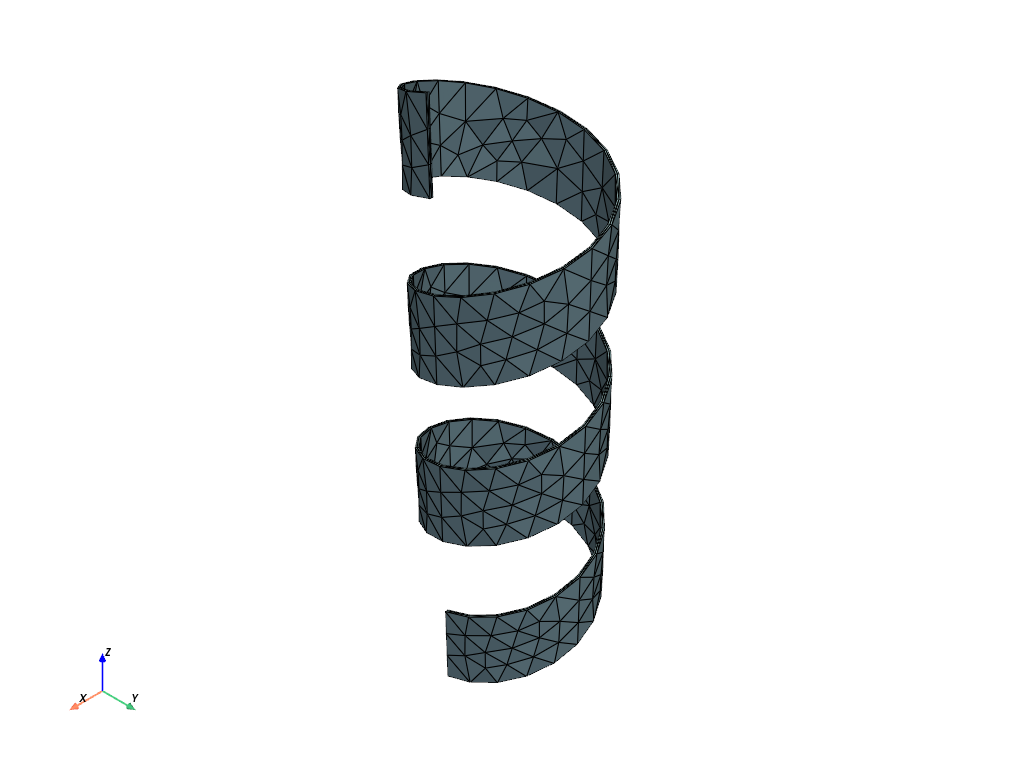

In [30]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/cube_mesh.png")

from IPython.display import Image
Image(filename='results/cube_mesh.png') 

### Un-comment this cell to see an interactive visualization of the mesh

In [31]:
# plotter.show()

## Define boundary and volume integration measure

In [32]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters

In [33]:
# Mechanical parameters
Geq_0   = Constant(domain, 15.0)         # Shear modulus, kPa
Kbulk = Constant(domain, PETSc.ScalarType(1.0e3*Geq_0))  # Bulk modulus, kPa
I_m     = Constant(domain, 175.0)        # Gent locking paramter

# Electrostatic  parameters
vareps_0 = Constant(domain, 8.85E-3)  #  permittivity of free space pF/mm
vareps_r = Constant(domain, 5.0)        #  relative permittivity, dimensionless
vareps   = vareps_r*vareps_0          #  permittivity of the material

# Simulation time-control related params

In [34]:
# start time (sec)
t = 0.0

# total simulation time (sec)
Ttot = 1.0

# number of steps for this simulation
numSteps = 100

# time step size (sec)
dt = Ttot/numSteps

# Create a constant for the time step
dk = Constant(domain, PETSc.ScalarType(dt))

# Final value of electric potential (kV)
phiTot = 2.0

# Function to linearly ramp up displacement on boundary.
def phiRamp(t):
    phi = phiTot*t/Ttot
    return phi

# Function spaces

In [35]:

U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,))  # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For pressure and electric potential
#
TH = mixed_element([U2, P1, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V2 = functionspace(domain, U2) # Vector function space
#
# Define actual functions with the required DOFs
w = Function(ME)
u, p, phi = split(w) # displacement u, presssure p, and electric potential phi

# A copy of functions to store values in the previous step
w_old  = Function(ME)
u_old,  p_old, phi_old = split(w_old)   

# Define test functions   
u_test, p_test, phi_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)

# Initial conditions

- The initial conditions for degrees of freedom $\mathbf{u}$, $p$, and $\phi$ are zero everywhere
- These are imposed automatically, since we have not specified any non-zero initial conditions.

# Subroutines for kinematics and constitutive equations

In [36]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)


#------------------------------------------------------------- 
# Subroutines for kinematics
#-------------------------------------------------------------

# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F = Id + grad(u) 
    return F


#------------------------------------------------------------- 
# Subroutines for calculating the electric field and displacement
#-------------------------------------------------------------

# Referential electric displacement 
def Dmat_calc(u, phi):
    F = F_calc(u)
    J = det(F)
    C = F.T*F
    e_R  = - grad(phi) # referential electric field
    Dmat = vareps * J* inv(C)*e_R
    return Dmat

#------------------------------------------------------------- 
# Subroutines for calculating the stress
#-------------------------------------------------------------

# Generalized shear modulus for Gent model
def Geq_Gent_calc(u):
    F = F_calc(u)
    J = det(F)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    z = I1-3
    z   = conditional( gt(z, I_m), 0.95*I_m, z ) # Keep from blowing up
    Geq_Gent  = Geq_0 * (I_m/(I_m - z))
    return Geq_Gent

# Mechanical Cauchy stress for Gent material
def T_mech_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Geq  = Geq_Gent_calc(u)
    T_mech = (1/J)* Geq * dev(Bdis) - p * Id
    return T_mech

# Maxwell contribution to the Cauchy stress
def T_maxw_calc(u,phi):
    F = F_calc(u)
    e_R  = - grad(phi)    # referential electric field
    e_sp = inv(F.T)*e_R   # spatial electric field 
    # Spatial Maxwel stress
    T_maxw = vareps*(outer(e_sp,e_sp) - 1/2*(inner(e_sp,e_sp))*Identity(3))
    return T_maxw


# Piola  stress
def T_mat_calc(u, p, phi):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T_mech = T_mech_calc(u,p)
    #
    T_maxw = T_maxw_calc(u,phi)
    #
    T      = T_mech + T_maxw
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

# Evaluate kinematics and constitutive relations

In [37]:
# Kinematical quantities
F  = F_calc(u)
J  = det(F)
C =  F.T*F
Fdis = J**(-1/3)*F
Cdis = J**(-2/3)*C
I1 = tr(Cdis)

# Mechanical Cauchy stress
T_mech = T_mech_calc(u, p)

# Electrostatic Cauchy stress
T_maxw =T_maxw_calc(u, phi) 

# Piola stress
Piola = T_mat_calc(u, p, phi)  

# Referential electric displacement
Dmat = Dmat_calc(u, phi)

# Weak forms

In [38]:
# The weak form for the equilibrium equation
#
Res_1  =  inner( Piola, grad(u_test))*dx
              
# The auxiliary equation for the pressure
#
Res_2 = inner((p/Kbulk + ln(J)/J) , p_test)*dx

#  The weak form for Gauss's equation
Res_3 = inner(Dmat, grad(phi_test))*dx 

# The total residual
Res = Res_1 + Res_2 + Res_3

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [39]:
# results file name
results_name = "helix"

# Function space for projection of results
P1 = element("Lagrange", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space

# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# First, define a function for setting up this kind of projection problem for visualization purposes:
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*dx
    L = ufl.inner(u, test)*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.
#
tensor_projection_problem = setup_projection(Piola, VV3)
Piola_temp = tensor_projection_problem.solve()

In [40]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
p_vis      = Function(VV1, name="p")
phi_vis    = Function(VV1, name="phi")

In [41]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())


In [42]:
# Stretch measure
I1_vis      = Function(VV1)
I1_vis.name = "I1"
I1_expr     = Expression(I1, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [43]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, phi_vis, # DOF outputs
        Mises_vis, T11, T22, T33, # stress outputs
        I1_vis, J_vis, # Kinematical outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    p_vis.interpolate(w.sub(1))
    phi_vis.interpolate(w.sub(2))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = tensor_projection_problem.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    #
    I1_vis.interpolate(I1_expr)
    J_vis.interpolate(J_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [44]:
# # computing the reaction force using the stress field
# traction = dot(Piola_temp, n)
# Force    = dot(traction, n)*ds(4)
# rxnForce = fem.form(Force) 

In [45]:
# # infrastructure for evaluating functions at a certain point efficiently
IntTol = 1.e-3 # tolerance for interpolating surface quantities, mesh is not totally precise.
pointForEval = np.array([5.1-IntTol, -IntTol, 35-IntTol])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEval).array

## Boundary condtions

In [46]:
# Constant for applied electric potential
phi_cons = Constant(domain,PETSc.ScalarType(phiRamp(0)))

# Find the specific DOFs which will be constrained.
Base_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(539))
Base_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(539))
Base_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(539))
#
Inside_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(541))
Outside_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(540))


# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, Base_u1_dofs, ME.sub(0).sub(0))  # u1 fix - Base
bcs_2 = dirichletbc(0.0, Base_u2_dofs, ME.sub(0).sub(1))  # u2 fix - Base
bcs_3 = dirichletbc(0.0, Base_u3_dofs, ME.sub(0).sub(2))  # u3 fix - Base
#
bcs_4 = dirichletbc(phi_cons, Outside_phi_dofs, ME.sub(2))  # phi ramp - Outside
bcs_5 = dirichletbc(0.0, Inside_phi_dofs, ME.sub(2))        # phi ground - Inside

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

## Define the nonlinear variational problem

In [47]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

##  Start calculation loop

In [48]:
# Give the step a descriptive name
step = "Actuate"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

# Iinitialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0)    

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
  
    # increment time
    t += dt 
    
    # update time variables in time-dependent BCs 
    phi_cons.value = phiRamp(t)
    
    # Solve the problem
    (iter, converged) = solver.solve(w)
        
    # Now we start the adaptive time-stepping and output storage procedure.
    #
    # First, we check if the newton solver actually converged.
    if converged: 
        
        # If the solver converged, we print the status of the solver, 
        # perform adaptive time-stepping updates, output results, and 
        # update degrees of freedom for the next step, w_old <- w.
        
        # increment counter
        ii += 1
        
        # Collect results from MPI ghost processes
        w.x.scatter_forward()
        
        # Print progress of calculation
        if ii%1 == 0:
          now = datetime.now()
          current_time = now.strftime("%H:%M:%S")
          print("Step: {} | Increment: {} | Iterations: {}".format(step, ii, iter))
          print("dt: {} | Simulation Time: {} s | Percent of total time: {}%".format(round(dt,4), round(t,4), round(100*t/Ttot,4)))
          print() 
                
        # Iteration-based adaptive time-stepping
        #
        # If the newton solver takes 3 or less iterations, 
        # increase the time step by a factor of 1.5:
        if iter<=3:
            dt = 1.5*dt
            dk.value =dt
            print("Time step increased from {} to {}".format(round(dt/1.5,4),round(dt,4)))
            print()
        # If the newton solver takes 9 or more iterations, 
        # decrease the time step by a factor of 2:
        elif iter>=9:
            dt = dt/2
            dk.value = dt
            print("Time step decreased from {} to {}".format(round(2.0*dt,4),round(dt,4)))
            print()
        # otherwise the newton solver took 4-8 iterations,
        # in which case leave the time step alone.
            
        # Write output to file
        writeResults(t)
       
        # Store time history variables at this time
        timeHist0[ii] = w.sub(0).sub(1).eval([5.1-IntTol, -IntTol, 35-IntTol],colliding_cells[0])[0] # time history of displacement at a point
        timeHist1[ii] = w.sub(2).eval([5.1-IntTol, -IntTol, 35-IntTol],colliding_cells[0])[0] # time history of voltage phi at a point
        timeHist2[ii] = t # current time
        
        # Update DOFs for next step
        w_old.x.array[:] = w.x.array

    # If solver doesn't converge we have to back up in time,
    # cut the size of the time step, and try solving again.
    else: # not(converged)
        
        # first, we back up in time
        # ( to un-do the current time step )
        t = t - float(dk)
        
        # Then, we cut back on the time step we're attempting.
        # (by a factor of 2)
        dt = dt/2.0
        dk.value = dt
        
        # Finally, we have to reset the degrees of freedom to their
        # "old" values before trying to solve again, otherwise the 
        # initial guess for w is retained from the "failed" solve attempt.
        w.x.array = w_old.x.array[:]
    
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Actuate | Increment: 1 | Iterations: 5
dt: 0.01 | Simulation Time: 0.01 s | Percent of total time: 1.0%

Step: Actuate | Increment: 2 | Iterations: 6
dt: 0.01 | Simulation Time: 0.02 s | Percent of total time: 2.0%

Step: Actuate | Increment: 3 | Iterations: 6
dt: 0.01 | Simulation Time: 0.03 s | Percent of total time: 3.0%

Step: Actuate | Increment: 4 | Iterations: 6
dt: 0.01 | Simulation Time: 0.04 s | Percent of total time: 4.0%

Step: Actuate | Increment: 5 | Iterations: 6
dt: 0.01 | Simulation Time: 0.05 s | Percent of total time: 5.0%

Step: Actuate | Increment: 6 | Iterations: 6
dt: 0.01 | Simulation Time: 0.06 s | Percent of total time: 6.0%

Step: Actuate | Increment: 7 | Iterations: 6
dt: 0.01 | Simulation Time: 0.07 s | Percent of total time: 7.0%

Step: Actuate | Increment: 8 | Iterations: 6
dt: 0.01 | Simulation Time: 0.08 s | Percent of total time: 8.0%

Step: Actuate | Incre

# Plot results

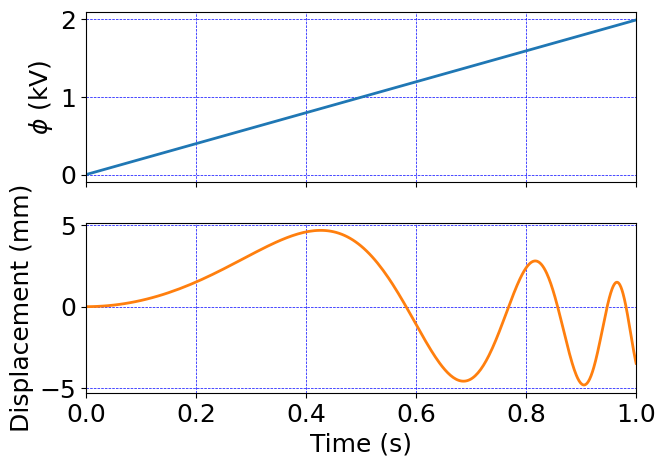

In [49]:
# set plot font to size 18
font = {'size'   : 18}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist2) + 1

fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

ax1.plot(timeHist2[0:ind], timeHist1[0:ind], c=colors[0], linewidth=2.0)
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel('$\phi$ (kV)')
# ax1.set_xlim([0,5])
# from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
# ax1.xaxis.set_minor_locator(AutoMinorLocator())
# ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(timeHist2[0:ind], timeHist0[0:ind], c=colors[1], linewidth=2.0)
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Displacement (mm)')
# from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
# ax2.xaxis.set_minor_locator(AutoMinorLocator())
# ax2.yaxis.set_minor_locator(AutoMinorLocator())
#plt.show()
ax2.set_xlim(0, 1)

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/helix_actuate_n1.png", dpi=600)
